In [0]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from node2vec import Node2Vec

from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing, feature_extraction
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.manifold import TSNE


In [0]:
G = nx.read_gml('datasets/verified.gml')

In [7]:
G.number_of_nodes(), G.number_of_edges()

(2901, 148998)

In [0]:
df = pd.read_csv("datasets/verified_features_all_300k.csv")


In [9]:
df.head()

,uid,name,friends_count,followers_count,listed_count,statuses_count,fake,desc_subjectivity,desc_polarity,tweets_subjectivity,tweets_polarity,help_empath,office_empath,dance_empath,money_empath,wedding_empath,domestic_work_empath,sleep_empath,medical_emergency_empath,cold_empath,hate_empath,cheerfulness_empath,aggression_empath,occupation_empath,envy_empath,anticipation_empath,family_empath,vacation_empath,crime_empath,attractive_empath,masculine_empath,prison_empath,health_empath,pride_empath,dispute_empath,nervousness_empath,government_empath,weakness_empath,horror_empath,swearing_terms_empath,...,car_empath,strength_empath,technology_empath,breaking_empath,shape_and_size_empath,power_empath,white_collar_job_empath,animal_empath,party_empath,terrorism_empath,smell_empath,disappointment_empath,poor_empath,plant_empath,pain_empath,beauty_empath,timidity_empath,philosophy_empath,negotiate_empath,negative_emotion_empath,cleaning_empath,messaging_empath,competing_empath,law_empath,friends_empath,payment_empath,achievement_empath,alcohol_empath,liquid_empath,feminine_empath,weapon_empath,children_empath,monster_empath,ocean_empath,giving_empath,contentment_empath,writing_empath,rural_empath,positive_emotion_empath,musical_empath
0,1172796973,PTorresTV,548,1117,25,12136,0,0.0,0.0,0.312530,0.093912,0.002503,0.001585,0.009541,0.001987,0.022792,0.006143,0.001275,0.004969,0.001119,0.001484,0.002110,0.001906,0.002433,0.000252,0.000335,0.022529,0.006821,0.006464,0.004830,0.002519,0.001867,0.004564,0.000811,0.003197,0.001057,0.001609,0.000786,0.001666,0.000564,...,0.002635,0.002138,0.001135,0.003647,0.003324,0.003090,0.001846,0.002806,0.025465,0.000869,0.000811,0.000255,0.000728,0.001924,0.002785,0.003471,0.000362,0.000564,0.000421,0.008620,0.001497,0.003283,0.004428,0.002260,0.012095,0.001400,0.004877,0.001386,0.001199,0.009170,0.002391,0.021099,0.001657,0.001920,0.003702,0.000585,0.002335,0.002460,0.007839,0.011049
1,1070586199,EOnlineUK,353,102733,316,60989,0,0.0,0.0,0.301738,0.076067,0.002964,0.001607,0.009846,0.002328,0.026361,0.004240,0.001340,0.005193,0.000997,0.002268,0.002397,0.001655,0.002799,0.000341,0.000426,0.025000,0.007094,0.007236,0.005456,0.002686,0.001401,0.003945,0.000644,0.001548,0.000615,0.001270,0.000671,0.001780,0.000781,...,0.002026,0.002605,0.000715,0.004427,0.003466,0.003349,0.001985,0.002708,0.027204,0.000938,0.000490,0.001479,0.001027,0.002718,0.004305,0.004376,0.000775,0.000859,0.000000,0.008997,0.001973,0.006104,0.002624,0.001301,0.014153,0.001880,0.003580,0.002036,0.000773,0.010398,0.002308,0.021205,0.002619,0.002023,0.005247,0.000557,0.002802,0.002584,0.009525,0.013514
2,25589776,people,1751,7565880,33588,267090,1,0.0,0.0,0.324708,0.069925,0.003162,0.002072,0.005707,0.001691,0.036405,0.007570,0.002665,0.009108,0.001742,0.002916,0.002973,0.001526,0.003040,0.000244,0.000000,0.036574,0.007104,0.010804,0.004247,0.003485,0.002225,0.006793,0.001354,0.004698,0.001298,0.000935,0.000529,0.001827,0.000253,...,0.001674,0.003602,0.000424,0.007852,0.002582,0.001888,0.002654,0.001892,0.022918,0.000275,0.000297,0.000229,0.002405,0.002017,0.003214,0.001937,0.000944,0.000215,0.000595,0.008619,0.000894,0.003928,0.004437,0.003553,0.017588,0.000739,0.005579,0.001528,0.001736,0.006831,0.002769,0.032744,0.000474,0.001301,0.002765,0.000771,0.004536,0.005398,0.009638,0.008561
3,1367531,FoxNews,398,18416786,65345,418052,0,0.0,0.0,0.214538,0.043671,0.002774,0.046930,0.018994,0.006579,0.009791,0.008204,0.011199,0.002914,0.001927,0.001500,0.001288,0.003173,0.041127,0.000827,0.000368,0.006522,0.004596,0.009982,0.001409,0.002729,0.003356,0.001161,0.000764,0.007287,0.000425,0.014573,0.000687,0.002105,0.000416,...,0.003357,0.002872,0.001384,0.001540,0.002608,0.004244,0.005401,0.015075,0.029000,0.003157,0.000226,0.002163,0.002644,0.003103,0.003314,0.000000,0.000453,0.001464,0.002801,0.006549,0.000687,0.004086,0.002189,0.007833,0.002333,0.005546,0.004129,0.000191,0.000191,0.002096,0.002891,0.004289,0.001988,0.001589,0.001920,0.000191,0.00328

In [0]:
names = list(df['name'].values)

In [0]:
sub_g = G.subgraph(names)

In [12]:
sub_g.number_of_nodes(), sub_g.number_of_edges()

(2900, 148998)

In [13]:
nodes = list(sub_g.nodes())

df = df[df['name'].isin(nodes)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2900 entries, 0 to 2901
Columns: 205 entries, uid to musical_empath
dtypes: float64(198), int64(6), object(1)
memory usage: 4.6+ MB


In [14]:
node2vec = Node2Vec(sub_g, dimensions=128, walk_length=40, num_walks=300, workers=1, p=.5, q=3)


Generating walks (CPU: 1): 100%|██████████| 300/300 [23:14<00:00,  4.63s/it]


In [15]:
vmodel = node2vec.fit()
vocab = list(vmodel.wv.vocab)
X_v = vmodel[vocab]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
target = []

for x in vocab:
    target.append(int(df.loc[df['name'] == x]['fake'])  )

In [0]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_v)

In [0]:
dfg = pd.DataFrame(X_tsne, columns=['x', 'y'])


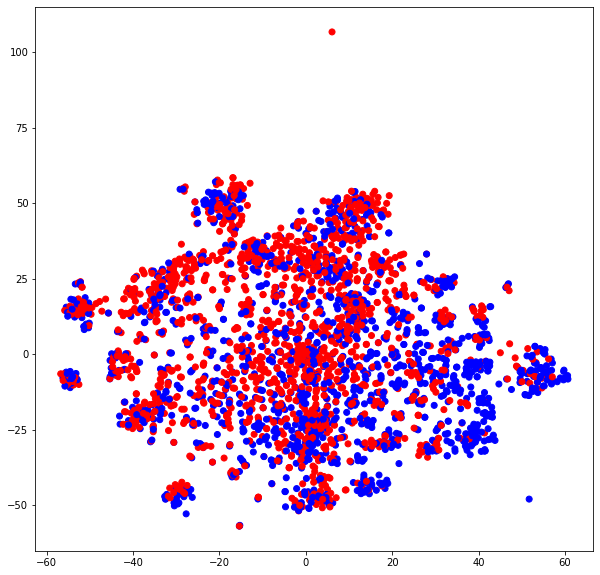

In [19]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
color= ['red' if l == 1 else 'blue' for l in target]
ax.scatter(dfg['x'], dfg['y'], color=color)

# for word, pos in dfg.iterrows():
#     ax.annotate(word, pos)
    
plt.show()

In [0]:
df = df.drop(columns=['fake', 'uid'])

In [0]:

X_feat = []
for n in vocab:
  feat = list(df[df['name'] == n].values[0][1:])
  mod = list(vmodel[n])
  X_feat.append(mod+feat)


In [0]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, calinski_harabaz_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV


In [0]:
import warnings
import xgboost as xgb
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

In [0]:
# vocab

In [0]:
X = X_feat
y= target

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)


In [0]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

### Naive Bayes

In [0]:
gnb = GaussianNB()

In [61]:
gnb.fit(scaled_X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [0]:
y_pred = gnb.predict(scaled_X_test)

In [63]:
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.55      0.76      0.64       263
           1       0.71      0.49      0.58       317

    accuracy                           0.61       580
   macro avg       0.63      0.62      0.61       580
weighted avg       0.64      0.61      0.60       580

Accuracy: 0.6103448275862069


### KNN

In [0]:
knn = KNeighborsClassifier(n_neighbors=10)

In [68]:
knn.fit(scaled_X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [0]:
y_pred = knn.predict(scaled_X_test)

In [70]:
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.62      0.72      0.66       263
           1       0.73      0.63      0.68       317

    accuracy                           0.67       580
   macro avg       0.67      0.67      0.67       580
weighted avg       0.68      0.67      0.67       580

Accuracy: 0.6706896551724137


### Logistic regression

In [0]:
lr = LogisticRegressionCV(cv=5,  
                          max_iter=10000)

In [72]:
lr.fit(scaled_X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=10000, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [0]:
test_preds_lr = lr.predict_proba(scaled_X_test)

In [0]:
# lr.score(test_data, test_targets)

In [0]:
# test_preds_lr[:, 1]

In [0]:
test_predictions_class_lr = ((test_preds_lr[:, 1]>=0.5)*1).flatten()
test_df_lr = pd.DataFrame({"Predicted_score": test_preds_lr[:, 1].flatten(), 
                        "Predicted_class": test_predictions_class_lr, 
                        "True": y_test})

In [79]:
pd.crosstab(test_df_lr['True'], test_df_lr['Predicted_class'])

Predicted_class,0,1
True,,
0,139,124
1,63,254


In [81]:
print(classification_report(y_test, test_df_lr['Predicted_class']))
print("Accuracy:", accuracy_score(y_test, test_df_lr['Predicted_class']))


              precision    recall  f1-score   support

           0       0.69      0.53      0.60       263
           1       0.67      0.80      0.73       317

    accuracy                           0.68       580
   macro avg       0.68      0.66      0.66       580
weighted avg       0.68      0.68      0.67       580

Accuracy: 0.6775862068965517


### SVM

In [82]:
#Create a svm Classifier
clf = svm.SVC(kernel='rbf', gamma='scale')
clf.fit(scaled_X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
y_pred = clf.predict(scaled_X_test)

In [84]:
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.76      0.59      0.66       263
           1       0.71      0.84      0.77       317

    accuracy                           0.73       580
   macro avg       0.73      0.72      0.72       580
weighted avg       0.73      0.73      0.72       580

Accuracy: 0.7275862068965517


### XGBoost

In [0]:
xgb_clf = xgb.XGBClassifier()

In [86]:
xgb_clf.fit(scaled_X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
pred = xgb_clf.predict(scaled_X_test)

In [91]:
print(classification_report(y_test, pred))
print("Accuracy:", accuracy_score(y_test, pred))

              precision    recall  f1-score   support

           0       0.74      0.62      0.67       263
           1       0.72      0.81      0.77       317

    accuracy                           0.73       580
   macro avg       0.73      0.72      0.72       580
weighted avg       0.73      0.73      0.72       580

Accuracy: 0.7275862068965517


### Random Forest

In [0]:
forest = RandomForestClassifier()


In [93]:
forest.fit(scaled_X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
pred = forest.predict(scaled_X_test)

In [96]:
print(classification_report(y_test, pred))
print("Accuracy:", accuracy_score(y_test, pred))

              precision    recall  f1-score   support

           0       0.60      0.71      0.66       263
           1       0.72      0.61      0.66       317

    accuracy                           0.66       580
   macro avg       0.66      0.66      0.66       580
weighted avg       0.67      0.66      0.66       580

Accuracy: 0.6586206896551724
